In [1]:
import torch # for some reason we need to do this first!


from root_pandas import read_root
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set()

Welcome to JupyROOT 6.08/06


In [2]:
cols=["Mpi0g1","Mpi0g2","Mpi0","Meta","Mpi0eta","mandelstam_tpi0","cosTheta_eta_gj","phi_eta_gj",
     "cosThetaHighestEphotonIneta_gj","pi0_energy","mcprocess"]

In [3]:
data = read_root('allMC_tree_ext_subset.root', 'degALL_acc_mEllipse_tree_flat',columns=cols)

Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


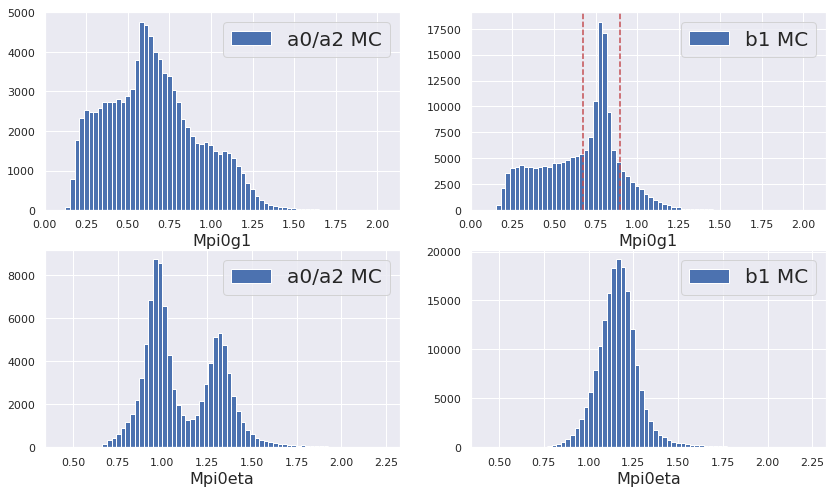

In [4]:
lowThresh=0.675
uppThresh=0.9

fig,ax=plt.subplots(2,2,figsize=(14,8))
ax=ax.flatten()

df=data

# Mpi0g
binedges=np.histogram(df.Mpi0g1,bins=70)[1]
df[(df.mcprocess==0)|(df.mcprocess==1)].Mpi0g1.hist(bins=binedges,ax=ax[0],label="a0/a2 MC")
df[df.mcprocess==2].Mpi0g1.hist(bins=binedges,ax=ax[1],label="b1 MC")
ax[0].set_xlabel("Mpi0g1",size=16)
ax[1].set_xlabel("Mpi0g1",size=16)
ax[0].legend(prop={"size":20})
ax[1].legend(prop={"size":20})
ax[1].axvline(uppThresh,c='r',linestyle="--")
ax[1].axvline(lowThresh,c='r',linestyle="--")

# Mpi0eta
binedges=np.histogram(df.Mpi0eta,bins=70)[1]
df[(df.mcprocess==0)|(df.mcprocess==1)].Mpi0eta.hist(bins=binedges,ax=ax[2],label="a0/a2 MC")
df[df.mcprocess==2].Mpi0eta.hist(bins=binedges,ax=ax[3],label="b1 MC")
ax[2].set_xlabel("Mpi0eta",size=16)
ax[3].set_xlabel("Mpi0eta",size=16)
ax[2].legend(prop={"size":20})
ax[3].legend(prop={"size":20})

In [5]:
df=data[(data.Mpi0g1<uppThresh)&(data.Mpi0g1>lowThresh)|(data.Mpi0g2<uppThresh)&(data.Mpi0g2>lowThresh)]
df=df[(df.mcprocess==0)|(df.mcprocess==1)|(df.mcprocess==2)]
df.mcprocess.loc[df.mcprocess==1]=0
df.mcprocess.loc[df.mcprocess==2]=1

mcprocess=df.mcprocess
df=df.drop(["Mpi0g1","Mpi0g2","mcprocess"],axis=1)

/d/home/ln16/.local/lib/python2.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
mcprocess.value_counts()

1    128299
0     42386
Name: mcprocess, dtype: int64

## Start coding the model

In [7]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,data,mcprocess):
        # import and initialize dataset
        self.x = data.values.astype(np.float32)
        self.y = mcprocess.values.astype(long)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        # returns length of data
        return len(self.x)

In [8]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = torch.nn.Linear(8, 100)
        # Output layer, 10 units - one for each digit
        self.output = torch.nn.Linear(100, 2)
        
        # Define sigmoid activation and softmax output 
        self.relu = torch.nn.ReLU()
        #self.softmax = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        #x = self.softmax(x)
        
        return x

In [9]:
torchData=dataset(df,mcprocess)

In [10]:
NUM_INSTANCES = len(torchData)
TEST_RATIO = 0.3
TEST_SIZE = int(NUM_INSTANCES * 0.3)
TRAIN_SIZE = NUM_INSTANCES - TEST_SIZE

print("Total Length: {0}".format(NUM_INSTANCES))

train_data, test_data = torch.utils.data.random_split(torchData, (TRAIN_SIZE, TEST_SIZE))
print("Train/Test sizes: {0},{1}".format(len(train_data), len(test_data)))

Total Length: 170685
Train/Test sizes: 119480,51205


In [11]:
# when splitting train and test sets, data loader for each dataset should be made separately
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle = False)

In [12]:
model = Network()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)  

In [16]:
num_step = len(train_loader)

for epoch in range(1):
    for i, (x, y) in enumerate(train_loader):
        outputs = model(x)

        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("epoch {0} completed".format(epoch))
#     if (epoch + 1) % 10 == 0:
#         print("Epoch: {}, Loss: {:.5f}".format(epoch + 1, loss.item()))

epoch 0 completed
